# KNN classifier for predicting day of week

In [2]:
import pandas as pd
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm #color maps
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from itertools import chain, combinations

## load features

In [3]:
features = pd.read_csv('../jv-features.csv')
cc_features = pd.read_csv('../cc-features.csv')
features = features.merge(cc_features[['date','PctPNC','PctWP']], on='date')

features.sample(5)

,date,Weekday,OtherPuzAns,BlockDensity,AvgHintLength,AvgAnswerLength,NumHints,NumOneWordHints,PctOneWdHints,PctPerplex,WeekdayNum,NumRepeatedAnswers,CumTotalAnswers,NumRepeatedAnswers_Norm,PctPNC,PctWP
2994,2002-04-12,Friday,48.323529,14.222222,17.352941,5.676471,68,18,26.470588,7.352941,4,58,59128,0.000014,20.588235,5.882353
6407,2011-10-26,Wednesday,77.947368,15.111111,19.092105,5.026316,76,6,7.894737,6.578947,2,67,90523,0.000010,26.315789,17.105263
1233,1997-06-11,Wednesday,76.833333,16.888889,14.615385,4.794872,78,17,21.794872,5.128205,2,67,35698,0.000024,21.794872,0.000000
3865,2004-09-07,Tuesday,77.512821,16.000000,17.538462,4.846154,78,7,8.974359,3.846154,1,74,68002,0.000014,28.205128,2.564103
6974,2013-05-15,Wednesday,67.473684,16.888889,20.171053,4.921053,76,3,3.947368,5.263158,2,70,95143,0.000010,38.157895,0.000000


In [4]:
class_labels = features.groupby(['WeekdayNum','Weekday']).size().reset_index()['Weekday'].tolist()

In [5]:
def powerset(iterable):
    combos = []
    for i in range(1,len(iterable)+1):
        for c in combinations(iterable, i):
            combos.append(list(c))
    return combos

## define variables

In [6]:
X = features[['AvgAnswerLength', 'NumRepeatedAnswers_Norm', 'PctWP']].to_numpy()
y = features[['WeekdayNum']].to_numpy()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 617, 
                                                    shuffle=True,
                                                    stratify=y)

## CV for k

In [8]:
kfold = StratifiedKFold(5,shuffle = True,random_state = 440)

In [9]:
def get_acc(model,X,y):
    pred = model.predict(X)
    return np.sum(pred == y)/len(y)

In [12]:
max_neighbors = 200

accs = np.zeros((5,max_neighbors))

j = 0

for train_index, test_index in kfold.split(X_train,y_train):
    print(f"CV iteration {j+1} of 5...")
    X_train_train, X_train_test = X_train[train_index], X_train[test_index]
    y_train_train, y_train_test = y_train[train_index], y_train[test_index]
    for i in range(1, max_neighbors+1):
        if i % 25 == 0:
            print(f"testing k = {i} (to {max_neighbors})")
        knn = KNeighborsClassifier(i)
        knn.fit(X_train_train, y_train_train.ravel())
        accs[j, i-1] = get_acc(knn,X_train_test,y_train_test.ravel())
    j+=1

CV iteration 1 of 5...
testing k = 25 (to 200)
testing k = 50 (to 200)
testing k = 75 (to 200)
testing k = 100 (to 200)
testing k = 125 (to 200)
testing k = 150 (to 200)
testing k = 175 (to 200)
testing k = 200 (to 200)
CV iteration 2 of 5...
testing k = 25 (to 200)
testing k = 50 (to 200)
testing k = 75 (to 200)
testing k = 100 (to 200)
testing k = 125 (to 200)
testing k = 150 (to 200)
testing k = 175 (to 200)
testing k = 200 (to 200)
CV iteration 3 of 5...
testing k = 25 (to 200)
testing k = 50 (to 200)
testing k = 75 (to 200)
testing k = 100 (to 200)
testing k = 125 (to 200)
testing k = 150 (to 200)
testing k = 175 (to 200)
testing k = 200 (to 200)
CV iteration 4 of 5...
testing k = 25 (to 200)
testing k = 50 (to 200)
testing k = 75 (to 200)
testing k = 100 (to 200)
testing k = 125 (to 200)
testing k = 150 (to 200)
testing k = 175 (to 200)
testing k = 200 (to 200)
CV iteration 5 of 5...
testing k = 25 (to 200)
testing k = 50 (to 200)
testing k = 75 (to 200)
testing k = 100 (to 200)


## plot CV accuracy

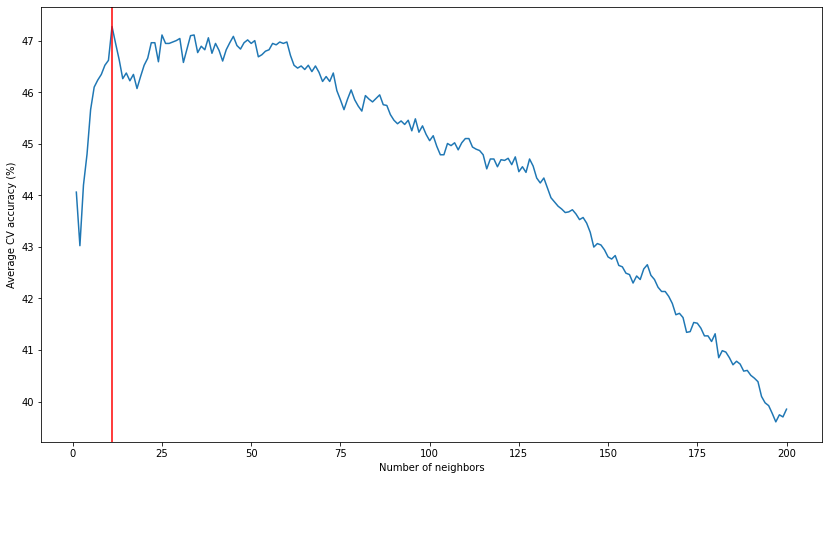

In [13]:
best_k = np.argmax(np.mean(accs, axis=0))+1
#sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(14,8))

ax.plot(range(1,max_neighbors+1),100*np.mean(accs,axis=0))
ax.axvline(x=best_k, color='r')
ax.annotate("best k",(best_k+1,37.3), fontsize=14)
ax.set_xlabel("Number of neighbors")
ax.set_ylabel("Average CV accuracy (%)")

plt.show()

In [14]:
print(f"The highest accuraccy is in the model with {best_k} neighbors.")

The highest accuraccy is in the model with 11 neighbors.


## CV for feature subset



In [15]:
feature_list = ['BlockDensity','OtherPuzAns','AvgAnswerLength','PctPerplex','PctOneWdHints','NumRepeatedAnswers_Norm', 'PctPNC','PctWP']
feature_combos = powerset(feature_list)

accs = np.zeros((5,len(feature_combos)))
precs = np.zeros((5,len(feature_combos)))
recs = np.zeros((5,len(feature_combos)))

for j, combo in enumerate(feature_combos):
    X = features[combo].to_numpy()
    y = features[['WeekdayNum']].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 617, 
                                                    shuffle=True,
                                                    stratify=y)
    kfold = StratifiedKFold(n_splits=5,shuffle = True,random_state=440)
    
    if j % 25 == 0:
        print(f"Iteration {j} of {len(feature_combos)}...")
    
    i=0
    for train_index, test_index in kfold.split(X_train, y_train):
        X_train_train, X_train_test = X_train[train_index], X_train[test_index]
        y_train_train, y_train_test = y_train[train_index], y_train[test_index]
        
        # value of k hardcoded here from previous CV
        knn = KNeighborsClassifier(11)
        knn.fit(X_train_train, y_train_train.ravel())
        
        y_predict = knn.predict(X_train_test)
        accs[i,j] = accuracy_score(y_train_test,y_predict)
        precs[i,j] = precision_score(y_train_test,y_predict,average='weighted',zero_division=0)
        recs[i,j] = recall_score(y_train_test,y_predict,average='weighted',zero_division=0)
        i = i + 1

Iteration 0 of 255...
Iteration 25 of 255...
Iteration 50 of 255...
Iteration 75 of 255...
Iteration 100 of 255...
Iteration 125 of 255...
Iteration 150 of 255...
Iteration 175 of 255...
Iteration 200 of 255...
Iteration 225 of 255...
Iteration 250 of 255...


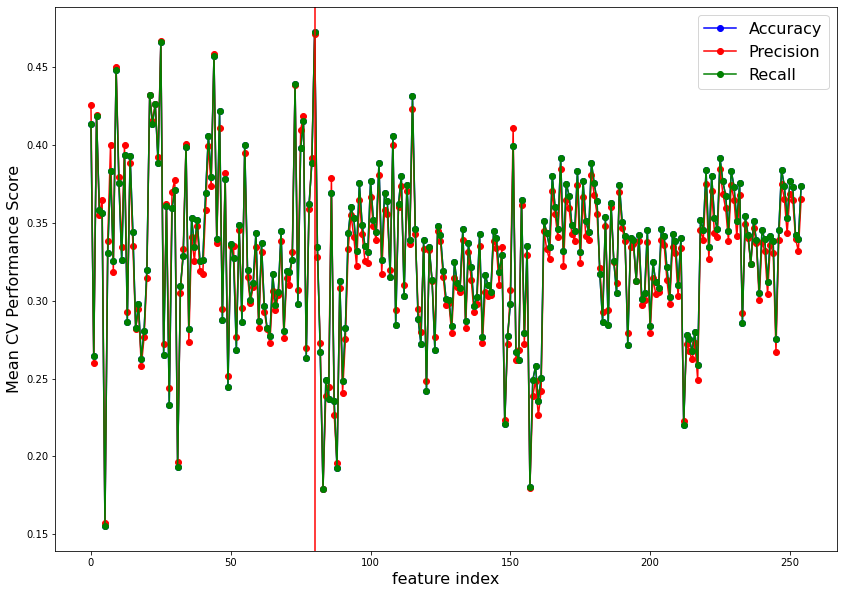

In [16]:
best_features = np.argmax(np.mean(accs, axis=0))
plt.figure(figsize=(14,10))

plt.plot(range(len(feature_combos)), np.mean(accs,axis=0),'b-o', label="Accuracy")
plt.plot(range(len(feature_combos)), np.mean(precs,axis=0),'r-o', label="Precision")
plt.plot(range(len(feature_combos)), np.mean(recs,axis=0),'g-o', label="Recall")
plt.axvline(x=best_features, color='r')
#plt.annotate("best depth",(best_k+1,37.3), fontsize=14)
plt.ylabel("Mean CV Performance Score",fontsize=16)
plt.xlabel("feature index",fontsize=16)

plt.legend(fontsize=16)

plt.show()

In [17]:
print(f"The highest accuraccy is in the model with the features {feature_combos[best_features]}.")

The highest accuraccy is in the model with the features ['AvgAnswerLength', 'NumRepeatedAnswers_Norm', 'PctWP'].


## confusion matrix for best model

In [18]:
X = features[feature_combos[best_features]].to_numpy()
y = features[['WeekdayNum']].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 617, 
                                                    shuffle=True,
                                                    stratify=y)

knn = KNeighborsClassifier(n_neighbors = best_k)

knn.fit(X_train,y_train.ravel())
best_k_acc = np.round(get_acc(knn,X_test,y_test.ravel())*100,2)

print(f"The model with {best_k} neighbors and the features {feature_combos[best_features]} has a {best_k_acc}% accuracy on the test set.")

The model with 11 neighbors and the features ['AvgAnswerLength', 'NumRepeatedAnswers_Norm', 'PctWP'] has a 45.86% accuracy on the test set.


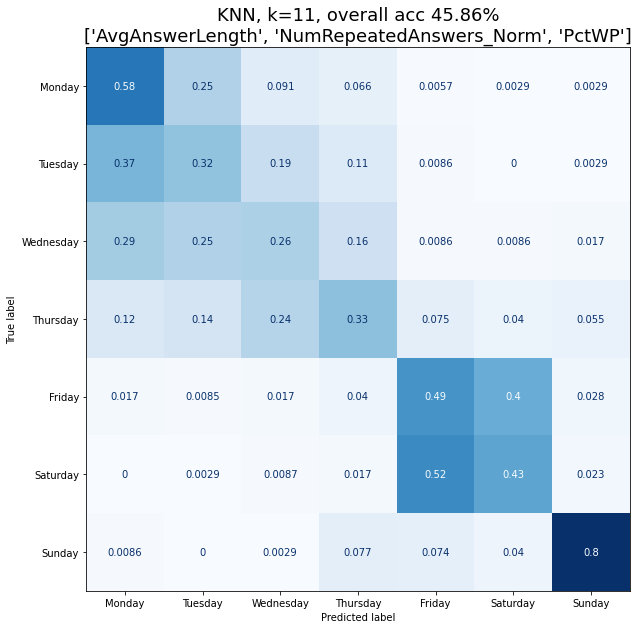

best features: ['AvgAnswerLength', 'NumRepeatedAnswers_Norm', 'PctWP']


In [21]:
fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(knn, X_test, y_test, 
                      display_labels=class_labels,
                      ax=ax, 
                      normalize='true',
                      cmap=cm.get_cmap('Blues'),
                      colorbar=False)
ax.set_title(f"KNN, k={best_k}, overall acc {best_k_acc}%\n{feature_combos[best_features]}", fontsize=18)
plt.savefig("knn-results.png")
plt.show()
print(f"best features: {feature_combos[best_features]}")